In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # colormaps 
                                        
%matplotlib inline

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
from statistics import mean

In [3]:
import torch
import torchvision

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
#from moe_models import moe_stochastic_model

### Generate dataset for training

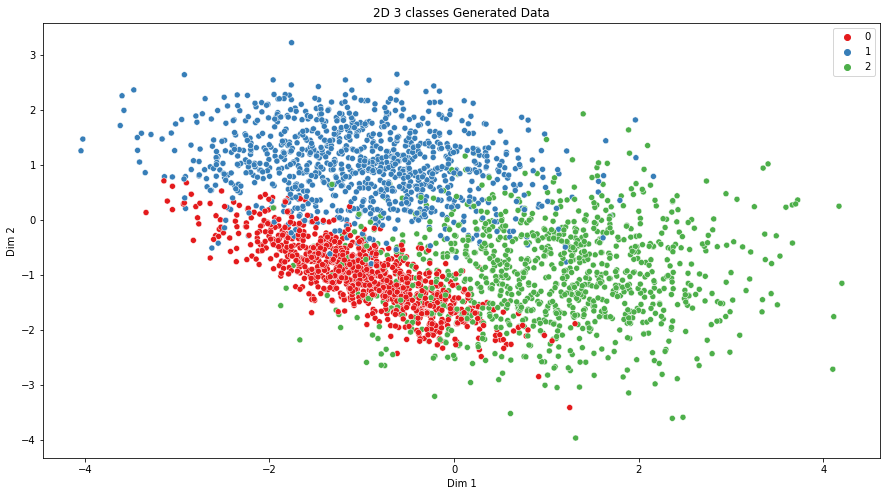

In [6]:
from sklearn.datasets import make_classification
# Easy decision boundary
X,y = make_classification(n_samples=3000, n_features=2, n_informative=2, 
                            n_redundant=0, n_repeated=0, n_classes=3, 
                            n_clusters_per_class=1,class_sep=1,flip_y=0,
                            random_state=17)
f, ax = plt.subplots(nrows=1, ncols=1,figsize=(15,8))
sns.scatterplot(x=X[:,0],y=X[:,1],hue=y,palette='Set1', ax=ax)
ax.set_title("2D 3 classes Generated Data")
plt.ylabel('Dim 2')
plt.xlabel('Dim 1')
plt.savefig('figures/moe_stochastic/generated_data.png')

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
print(len(y_train))
print(len(y_test))

2400
600


In [9]:
# Create trainloader
batchsize = 32
trainset = torch.utils.data.TensorDataset(torch.tensor(x_train, dtype=torch.float32), 
                                          torch.tensor(y_train, dtype=torch.long))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                        shuffle=True, num_workers=2)
testset = torch.utils.data.TensorDataset(torch.tensor(x_test, dtype=torch.float32),
                                         torch.tensor(y_test, dtype=torch.long))
testloader = torch.utils.data.DataLoader(testset, batch_size=y_test.shape[0],
                                        shuffle=True, num_workers=2)

### Networks and callbacks

In [10]:
# The selector layer that outputs a stochastic selection of an expert based on the gate probabilities. 
# It is a non trainable layer 
class moe_stochastic_model(nn.Module):
    
    def __init__(self, num_experts, experts, gate):
        super(moe_stochastic_model,self).__init__()
        self.num_experts = num_experts
        self.experts = experts
        self.gate = gate
        
        
    def forward(self,input):
        batch_size = input.shape[0]
        if batch_size > 1:
            x = []
            for i, expert in enumerate(self.experts):
                x.append(expert(input))
            x = torch.stack(x)
            x.transpose_(0,1)
            
            p = self.gate(input)
            
            sample = torch.multinomial(p, 1)   
            
            output = torch.cat([x[i][sample[i]] for i in range(batch_size)])
        else:
            output = self.experts[0](input)

        return output
    
    def train(self, trainloader, testloader, optimizer, loss_criterion, accuracy, epochs):
        expert_models = self.experts
        gate_model = self.gate
        running_loss = 0.0
        train_running_accuracy = 0.0
        test_running_accuracy = 0.0
        history = {'loss':[], 'accuracy':[], 'val_accuracy':[]}
        for epoch in range(epochs):  # loop over the dataset multiple times
            for i, data in enumerate(trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data


                # zero the parameter gradients
                optimizer.zero_grad()

                x = []
                for j, expert in enumerate(expert_models):
                    x.append(expert(inputs)) 
                x = torch.stack(x)
                p = gate_model(inputs)

                loss = loss_criterion(x, p , labels)
                loss.backward()

                optimizer.step()

                running_loss += loss.item()

                outputs = self(inputs)
                acc = accuracy(outputs, labels)
                train_running_accuracy += acc


            acc = 0.0
            for j, test_data in enumerate(testloader, 0):
                test_input, test_labels = test_data
                test_outputs = self(test_input)
                acc += accuracy(test_outputs, test_labels)
            test_running_accuracy = (acc/(j+1))

            running_loss = running_loss / (i+1)
            train_running_accuracy = train_running_accuracy / (i+1)
            history['loss'].append(running_loss)
            history['accuracy'].append(train_running_accuracy)
            history['val_accuracy'].append(test_running_accuracy)
            print('epoch', epoch,
                  'training loss',
                  running_loss,
                  ', training accuracy',
                  train_running_accuracy,
                  ', test accuracy',
                  test_running_accuracy)
            running_loss = 0.0
            train_running_accuracy = 0.0
            test_running_accuracy = 0.0
        return history



In [11]:
#Expert network
class expert_layers(nn.Module):
    def __init__(self):
        super(expert_layers, self).__init__()
        self.model = nn.Sequential(
                    nn.Linear(2, 4),
                    nn.ReLU(),
                    nn.Linear(4,3),
                    nn.Softmax(dim=1)
                )        
        
    def forward(self, input):
        return self.model(input)


In [12]:
# create a set of experts
def experts(num_experts):
    models = []
    for i in range(num_experts):
        models.append(expert_layers())
    return nn.ModuleList(models)

In [13]:
#Gate network (Similar to the expert layer)
class gate_layers(nn.Module):
    def __init__(self, num_experts):
        super(gate_layers, self).__init__()
        self.model = nn.Sequential(
                    nn.Linear(2, 4),
                    nn.ReLU(),
                    nn.Linear(4,num_experts),
                    nn.Softmax(dim=1)
                )
        
    def forward(self, input):
        return self.model(input)

### Mixture of experts model

In [14]:
# compute
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [15]:
def moe_stochastic_loss(expert_outputs, gate_output, target):
    expert_loss = []
    criterion = nn.CrossEntropyLoss(reduction='none')
    for i in range(expert_outputs.shape[0]):
        cross_entropy_loss = criterion(expert_outputs[i], target)
        expert_loss.append(cross_entropy_loss)
    expert_loss = torch.stack(expert_loss)
    expert_loss.transpose_(0,1)
    expected_loss = torch.sum(gate_output * expert_loss, 1)
    loss = torch.mean(expected_loss)
    return loss    

In [16]:
# experiment with models with different number of experts
models = {}
total_experts = 4
history = []
for num_experts in range(1, total_experts+1):
    print('Number of experts ', num_experts)
    expert_models = experts(num_experts)
    gate_model = gate_layers(num_experts)
    moe_model = moe_stochastic_model(num_experts, expert_models, gate_model)
    optimizer = optim.RMSprop(moe_model.parameters(),
                              lr=0.001, momentum=0.9)
    hist = moe_model.train(trainloader, testloader, optimizer, moe_stochastic_loss, accuracy, epochs=10)
    history.append(hist)
    models[num_experts] = moe_model

Number of experts  1
epoch 0 training loss 0.8110431822141012 , training accuracy tensor(0.7583) , test accuracy tensor(0.8600)
epoch 1 training loss 0.6916773176193237 , training accuracy tensor(0.8654) , test accuracy tensor(0.8717)
epoch 2 training loss 0.682225623925527 , training accuracy tensor(0.8671) , test accuracy tensor(0.8767)
epoch 3 training loss 0.6794004925092061 , training accuracy tensor(0.8704) , test accuracy tensor(0.8750)
epoch 4 training loss 0.6769358476003011 , training accuracy tensor(0.8733) , test accuracy tensor(0.8717)
epoch 5 training loss 0.6751636854807536 , training accuracy tensor(0.8758) , test accuracy tensor(0.8700)
epoch 6 training loss 0.6731390698750814 , training accuracy tensor(0.8775) , test accuracy tensor(0.8700)
epoch 7 training loss 0.6718256084124247 , training accuracy tensor(0.8804) , test accuracy tensor(0.8717)
epoch 8 training loss 0.6729196413358053 , training accuracy tensor(0.8813) , test accuracy tensor(0.8650)
epoch 9 training 

### Visualise decision boundaries of mixture of expert model, expert model and gate model

In [17]:
#create meshgrid
resolution = 100 # 100x100 background pixels
a2d_min, a2d_max = np.min(X[:,0]), np.max(X[:,0])
b2d_min, b2d_max = np.min(X[:,1]), np.max(X[:,1])
a, b = np.meshgrid(np.linspace(a2d_min, a2d_max, resolution), 
                   np.linspace(b2d_min, b2d_max, resolution))
generated_data = torch.tensor(np.c_[a.ravel(), b.ravel()], dtype=torch.float32)

In [18]:
def labels(p, palette=['r','c','y']):
    pred_labels = torch.argmax(p, dim=1)
    uniq_y = np.unique(pred_labels)
    pred_color = [palette[i] for i in uniq_y]
    return pred_color, pred_labels

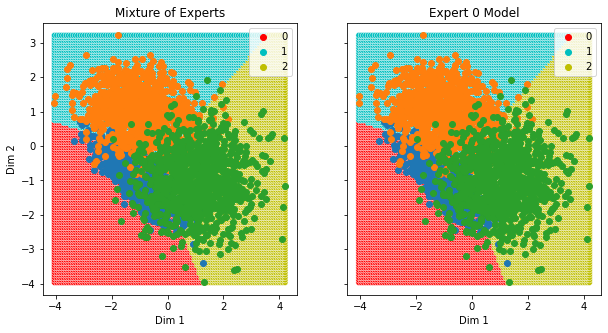

In [19]:
moe_model = models[1]
pred = moe_model(generated_data)
pred_color,pred_labels = labels(pred)

experts = moe_model.experts

pred_exp_0 = experts[0](generated_data)
pred_exp_0_color,pred_exp_0_labels = labels(pred_exp_0)

nrows = 1
ncols = 2
thefigsize = (ncols*5,nrows*5)
fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=thefigsize)
ax = ax.flatten()
sns.scatterplot(x=generated_data[:,0],y=generated_data[:,1],
                hue=pred_labels,palette=pred_color, ax=ax[0])
ax[0].scatter(X[y==0, 0], X[y==0,1], color='tab:blue')
ax[0].scatter(X[y==1, 0], X[y==1,1], color='tab:orange')
ax[0].scatter(X[y==2, 0], X[y==2,1], color='tab:green')
ax[0].set_title('Mixture of Experts')
ax[0].set_ylabel('Dim 2')
ax[0].set_xlabel('Dim 1')


sns.scatterplot(x=generated_data[:,0],y=generated_data[:,1],
                hue=pred_exp_0_labels,palette=pred_exp_0_color, ax=ax[1])
ax[1].scatter(X[y==0, 0], X[y==0,1], color='tab:blue')
ax[1].scatter(X[y==1, 0], X[y==1,1], color='tab:orange')
ax[1].scatter(X[y==2, 0], X[y==2,1], color='tab:green')
ax[1].set_title('Expert 0 Model')
ax[1].set_ylabel('Dim 2')
ax[1].set_xlabel('Dim 1')

plt.savefig('figures/moe_stochastic/1_expert_stochastic.png')

plt.show()

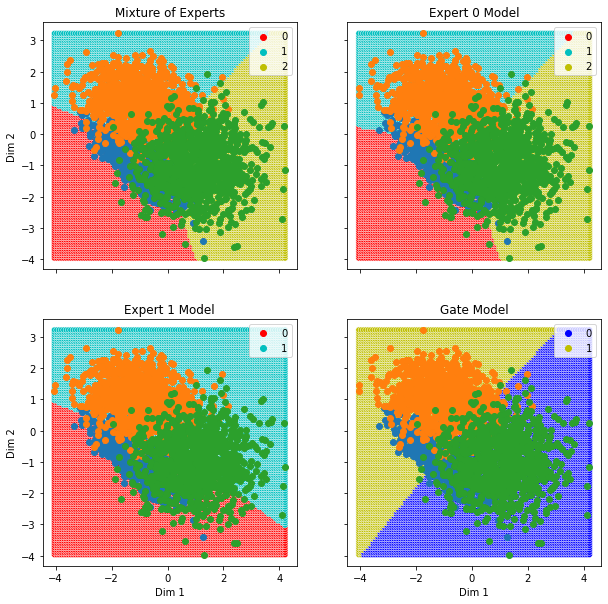

In [20]:
moe_model = models[2]
pred = moe_model(generated_data)
pred_color, pred_labels = labels(pred)

experts = moe_model.experts

pred_exp_0 = experts[0](generated_data)
pred_exp_0_color,pred_exp_0_labels = labels(pred_exp_0)

pred_exp_1 = experts[1](generated_data)
pred_exp_1_color,pred_exp_1_labels = labels(pred_exp_1)

pred_gate = moe_model.gate(generated_data)
pred_gate_color, pred_gate_labels = labels(pred_gate, ['b','y','m','k'])

nrows = 2
ncols = 2
thefigsize = (ncols*5,nrows*5)
fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=thefigsize)
ax = ax.flatten()
sns.scatterplot(x=generated_data[:,0],y=generated_data[:,1],
                hue=pred_labels,palette=pred_color, ax=ax[0])
ax[0].scatter(X[y==0, 0], X[y==0,1], color='tab:blue')
ax[0].scatter(X[y==1, 0], X[y==1,1], color='tab:orange')
ax[0].scatter(X[y==2, 0], X[y==2,1], color='tab:green')
ax[0].set_title('Mixture of Experts')
ax[0].set_ylabel('Dim 2')
ax[0].set_xlabel('Dim 1')

sns.scatterplot(x=generated_data[:,0],y=generated_data[:,1],
                hue=pred_exp_0_labels,palette=pred_exp_0_color, ax=ax[1])
ax[1].scatter(X[y==0, 0], X[y==0,1], color='tab:blue')
ax[1].scatter(X[y==1, 0], X[y==1,1], color='tab:orange')
ax[1].scatter(X[y==2, 0], X[y==2,1], color='tab:green')
ax[1].set_title('Expert 0 Model')
ax[1].set_ylabel('Dim 2')
ax[1].set_xlabel('Dim 1')

sns.scatterplot(x=generated_data[:,0],y=generated_data[:,1],
                hue=pred_exp_1_labels,palette=pred_exp_1_color, ax=ax[2])
ax[2].scatter(X[y==0, 0], X[y==0,1], color='tab:blue')
ax[2].scatter(X[y==1, 0], X[y==1,1], color='tab:orange')
ax[2].scatter(X[y==2, 0], X[y==2,1], color='tab:green')
ax[2].set_title('Expert 1 Model')
ax[2].set_ylabel('Dim 2')
ax[2].set_xlabel('Dim 1')

sns.scatterplot(x=generated_data[:,0],y=generated_data[:,1],
                hue=pred_gate_labels,palette=pred_gate_color, ax=ax[3])
ax[3].scatter(X[y==0, 0], X[y==0,1], color='tab:blue')
ax[3].scatter(X[y==1, 0], X[y==1,1], color='tab:orange')
ax[3].scatter(X[y==2, 0], X[y==2,1], color='tab:green')
ax[3].set_title('Gate Model')
ax[3].set_ylabel('Dim 2')
ax[3].set_xlabel('Dim 1')

plt.savefig('figures/moe_stochastic/2_expert_stochastic.png')

plt.show()

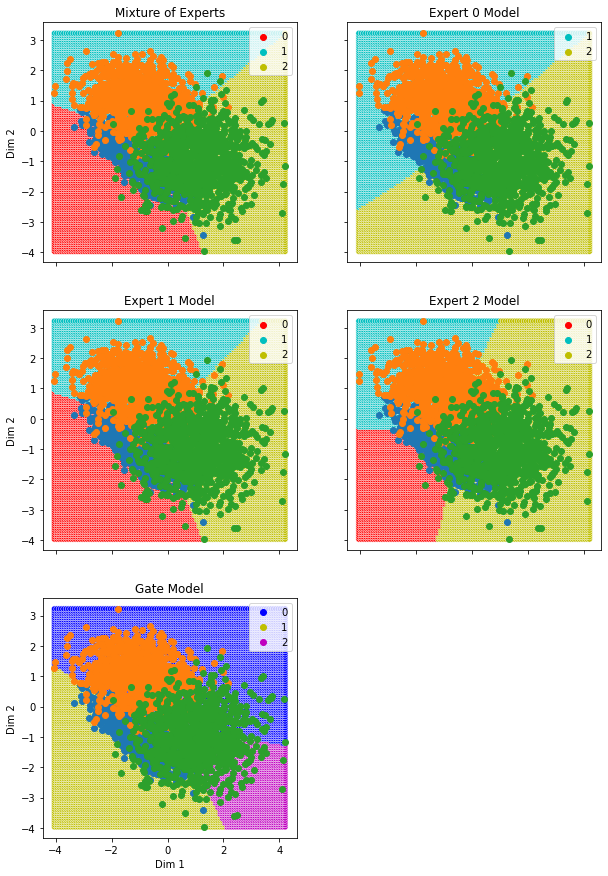

In [21]:
moe_model = models[3]
pred = moe_model(generated_data)
pred_color, pred_labels = labels(pred)

experts = moe_model.experts

pred_exp_0 = experts[0](generated_data)
pred_exp_0_color, pred_exp_0_labels = labels(pred_exp_0)

pred_exp_1 = experts[1](generated_data)
pred_exp_1_color,  pred_exp_1_labels = labels(pred_exp_1)

pred_exp_2 = experts[2](generated_data)
pred_exp_2_color,  pred_exp_2_labels = labels(pred_exp_2)

pred_gate = moe_model.gate(generated_data)
pred_gate_color, pred_gate_labels = labels(pred_gate, ['b','y','m','k'])

nrows = 3
ncols = 2
thefigsize = (ncols*5,nrows*5)
fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=thefigsize)
ax = ax.flatten()
sns.scatterplot(x=generated_data[:,0],y=generated_data[:,1],
                hue=pred_labels,palette=pred_color, ax=ax[0])
ax[0].scatter(X[y==0, 0], X[y==0,1], color='tab:blue')
ax[0].scatter(X[y==1, 0], X[y==1,1], color='tab:orange')
ax[0].scatter(X[y==2, 0], X[y==2,1], color='tab:green')
ax[0].set_title('Mixture of Experts')
ax[0].set_ylabel('Dim 2')
ax[0].set_xlabel('Dim 1')

sns.scatterplot(x=generated_data[:,0],y=generated_data[:,1],
                hue=pred_exp_0_labels,palette=pred_exp_0_color, ax=ax[1])
ax[1].scatter(X[y==0, 0], X[y==0,1], color='tab:blue')
ax[1].scatter(X[y==1, 0], X[y==1,1], color='tab:orange')
ax[1].scatter(X[y==2, 0], X[y==2,1], color='tab:green')
ax[1].set_title('Expert 0 Model')
ax[1].set_ylabel('Dim 2')
ax[1].set_xlabel('Dim 1')

sns.scatterplot(x=generated_data[:,0],y=generated_data[:,1],
                hue=pred_exp_1_labels,palette=pred_exp_1_color, ax=ax[2])
ax[2].scatter(X[y==0, 0], X[y==0,1], color='tab:blue')
ax[2].scatter(X[y==1, 0], X[y==1,1], color='tab:orange')
ax[2].scatter(X[y==2, 0], X[y==2,1], color='tab:green')
ax[2].set_title('Expert 1 Model')
ax[2].set_ylabel('Dim 2')
ax[2].set_xlabel('Dim 1')

sns.scatterplot(x=generated_data[:,0],y=generated_data[:,1],
                hue=pred_exp_2_labels,palette=pred_exp_2_color, ax=ax[3])
ax[3].scatter(X[y==0, 0], X[y==0,1], color='tab:blue')
ax[3].scatter(X[y==1, 0], X[y==1,1], color='tab:orange')
ax[3].scatter(X[y==2, 0], X[y==2,1], color='tab:green')
ax[3].set_title('Expert 2 Model')
ax[3].set_ylabel('Dim 2')
ax[3].set_xlabel('Dim 1')

    
sns.scatterplot(x=generated_data[:,0],y=generated_data[:,1],
                hue=pred_gate_labels,palette=pred_gate_color, ax=ax[4])
ax[4].scatter(X[y==0, 0], X[y==0,1], color='tab:blue')
ax[4].scatter(X[y==1, 0], X[y==1,1], color='tab:orange')
ax[4].scatter(X[y==2, 0], X[y==2,1], color='tab:green')
ax[4].set_title('Gate Model')
ax[4].set_ylabel('Dim 2')
ax[4].set_xlabel('Dim 1')

ax[5].axis('off')
plt.savefig('figures/moe_stochastic/3_expert_stochastic.png')

plt.show()



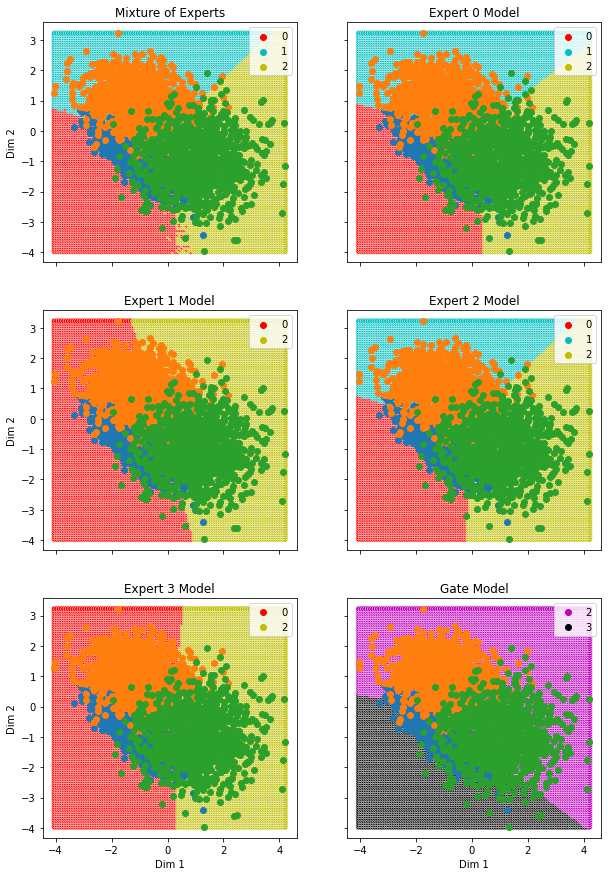

In [22]:
moe_model = models[4]
pred = moe_model(generated_data)
pred_color, pred_labels = labels(pred)

experts = moe_model.experts

pred_exp_0 = experts[0](generated_data)
pred_exp_0_color, pred_exp_0_labels = labels(pred_exp_0)

pred_exp_1 = experts[1](generated_data)
pred_exp_1_color,  pred_exp_1_labels = labels(pred_exp_1)

pred_exp_2 = experts[2](generated_data)
pred_exp_2_color,  pred_exp_2_labels = labels(pred_exp_2)

pred_exp_3 = experts[3](generated_data)
pred_exp_3_color,  pred_exp_3_labels = labels(pred_exp_3)

pred_gate = moe_model.gate(generated_data)
pred_gate_color, pred_gate_labels = labels(pred_gate, ['b','y','m','k'])

nrows = 3
ncols = 2
thefigsize = (ncols*5,nrows*5)
fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=thefigsize)
ax = ax.flatten()
sns.scatterplot(x=generated_data[:,0],y=generated_data[:,1],
                hue=pred_labels,palette=pred_color, ax=ax[0])
ax[0].scatter(X[y==0, 0], X[y==0,1], color='tab:blue')
ax[0].scatter(X[y==1, 0], X[y==1,1], color='tab:orange')
ax[0].scatter(X[y==2, 0], X[y==2,1], color='tab:green')
ax[0].set_title('Mixture of Experts')
ax[0].set_ylabel('Dim 2')
ax[0].set_xlabel('Dim 1')

sns.scatterplot(x=generated_data[:,0],y=generated_data[:,1],
                hue=pred_exp_0_labels,palette=pred_exp_0_color, ax=ax[1])
ax[1].scatter(X[y==0, 0], X[y==0,1], color='tab:blue')
ax[1].scatter(X[y==1, 0], X[y==1,1], color='tab:orange')
ax[1].scatter(X[y==2, 0], X[y==2,1], color='tab:green')
ax[1].set_title('Expert 0 Model')
ax[1].set_ylabel('Dim 2')
ax[1].set_xlabel('Dim 1')

sns.scatterplot(x=generated_data[:,0],y=generated_data[:,1],
                hue=pred_exp_1_labels,palette=pred_exp_1_color, ax=ax[2])
ax[2].scatter(X[y==0, 0], X[y==0,1], color='tab:blue')
ax[2].scatter(X[y==1, 0], X[y==1,1], color='tab:orange')
ax[2].scatter(X[y==2, 0], X[y==2,1], color='tab:green')
ax[2].set_title('Expert 1 Model')
ax[2].set_ylabel('Dim 2')
ax[2].set_xlabel('Dim 1')

sns.scatterplot(x=generated_data[:,0],y=generated_data[:,1],
                hue=pred_exp_2_labels,palette=pred_exp_2_color, ax=ax[3])
ax[3].scatter(X[y==0, 0], X[y==0,1], color='tab:blue')
ax[3].scatter(X[y==1, 0], X[y==1,1], color='tab:orange')
ax[3].scatter(X[y==2, 0], X[y==2,1], color='tab:green')
ax[3].set_title('Expert 2 Model')
ax[3].set_ylabel('Dim 2')
ax[3].set_xlabel('Dim 1')

sns.scatterplot(x=generated_data[:,0],y=generated_data[:,1],
                hue=pred_exp_3_labels,palette=pred_exp_3_color, ax=ax[4])
ax[4].scatter(X[y==0, 0], X[y==0,1], color='tab:blue')
ax[4].scatter(X[y==1, 0], X[y==1,1], color='tab:orange')
ax[4].scatter(X[y==2, 0], X[y==2,1], color='tab:green')
ax[4].set_title('Expert 3 Model')
ax[4].set_ylabel('Dim 2')
ax[4].set_xlabel('Dim 1')

sns.scatterplot(x=generated_data[:,0],y=generated_data[:,1],
                hue=pred_gate_labels,palette=pred_gate_color, ax=ax[5])
ax[5].scatter(X[y==0, 0], X[y==0,1], color='tab:blue')
ax[5].scatter(X[y==1, 0], X[y==1,1], color='tab:orange')
ax[5].scatter(X[y==2, 0], X[y==2,1], color='tab:green')
ax[5].set_title('Gate Model')
ax[5].set_ylabel('Dim 2')
ax[5].set_xlabel('Dim 1')

plt.savefig('figures/moe_stochastic/4_expert_stochastic.png')

plt.show()



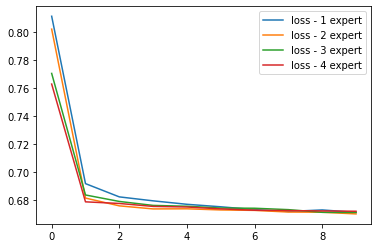

In [20]:
labels = []
for num_experts, hist in enumerate(history,0):
    plt.plot(range(len(hist['loss'])), hist['loss'])
    labels.append('loss - ' +str(num_experts+1)+' expert')
plt.legend(labels)
plt.savefig('figures/moe_stochastic/loss_moe_stochastic.png')
plt.show()

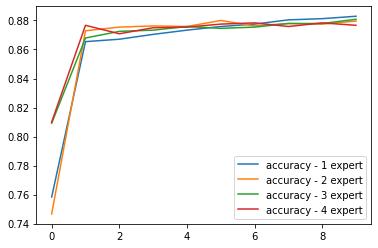

In [21]:
labels = []
for num_experts, hist in enumerate(history,0):
    plt.plot(range(len(hist['accuracy'])), hist['accuracy'])
    labels.append('accuracy - ' +str(num_experts+1)+' expert')
plt.legend(labels)
plt.savefig('figures/moe_stochastic/accuracy_moe_stochastic.png')
plt.show()

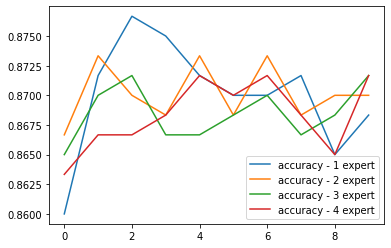

In [22]:
labels = []
for num_experts, hist in enumerate(history,0):
    plt.plot(range(len(hist['val_accuracy'])), hist['val_accuracy'])
    labels.append('accuracy - ' +str(num_experts+1)+' expert')
plt.legend(labels)
plt.savefig('figures/moe_stochastic/accuracy_moe_stochastic.png')
plt.show()